<a href="https://colab.research.google.com/github/blackBagel/Sarcasm-Detection-Learn/blob/main/sarcasm_detection_simple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -U eli5 clean-text

     |████████████████████████████████| 112kB 3.5MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45612 sha256=bd3ecdde8bb10f70c5e56b17ef747302e4dd26cb2bc5a2eb7fd92af112442568
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=2f759a8b8631be3b2e7f71c872cf0dd6ceb34cc09236ee8d3902941c00076006
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built ftfy emoji


In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
from google.colab import drive
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import spacy
import re
from cleantext import clean
from joblib import Parallel, delayed
from sklearn import preprocessing, decomposition, model_selection, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import eli5
import matplotlib.pyplot as plt
%matplotlib inline

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data preparation

In [3]:
DRIVE_PATH = '/gdrive/My Drive/Reddit sarcasm'
drive.mount('/gdrive')
os.chdir(DRIVE_PATH)

Mounted at /gdrive


In [4]:
DATA_COLUMNS = [
    'label',
    'comment',
    'author',
    'subreddit',
    'score',
    'ups',
    'downs',
    'date',
    'created_utc',
    'parent_comment'
]

full_comments_df = pd.read_csv("train-balanced-sarc.csv", delimiter='\t', names=DATA_COLUMNS)

## Methodology

First, let's see the data distributions

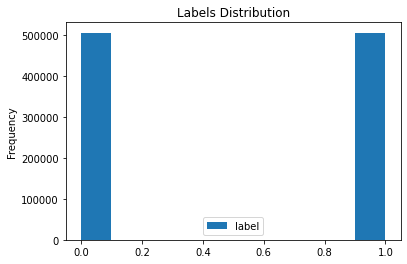

In [5]:
full_comments_df.plot(kind='hist', y='label', title = 'Labels Distribution')

The data is balanced with regard to the labels. Therefore, I'll use the accuracy metric to evaluate all future models.

I prefer to evaluate all the models based primarily on accuracy. The data is well balanced and there is no actual buisiness problem i'm solving here, so there's not much of a need to specifically avoid either FPs or FNs.

I will however keep the precision and recall scores of all models for future reference

#### Train-Validation-Test Split 

The dataset is quite relatively large with about 1 million comments. For that reason, it is quite reasonable to use only 4% of the data as test and validation sets, since they'll still be 20k each.

That way, we'll have lots of data to train on.

In [34]:
comments_df_without_labels = full_comments_df.iloc[:, 1:]

# We use the same train-test split to test all of the next models
df_train, df_test, labels_train, labels_test = train_test_split(comments_df_without_labels,
                                                                full_comments_df['label'],
                                                                random_state=1,
                                                                test_size=0.04,
                                                                shuffle=True)

df_val, df_test, labels_val, labels_test = train_test_split(df_test,
                                                            labels_test,
                                                            random_state=5,
                                                            test_size=0.5,
                                                            shuffle=True)

Let's make sure the validation and test set have similar distributions

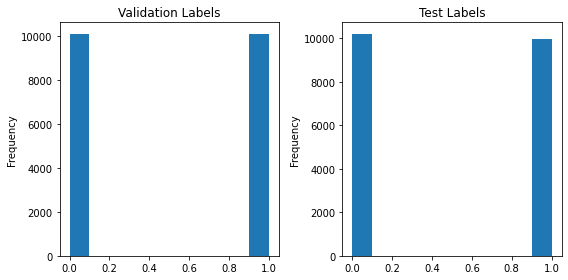

In [7]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))

labels_val.plot.hist(ax = axes[0], title='Validation Labels')
labels_test.plot.hist(ax = axes[1], title='Test Labels')
fig.tight_layout()

#### Null handling

In [8]:
print("Nulls in training set:")
df_train.isnull().sum()

Nulls in training set:


comment           51
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

Since I don't want to divide and reassemble the data and the labels each time i apply a function to both, i'll simply create a function that applies row based functions to them and handles the dividing and reassembling for me

In [9]:
def handle_row_dropping_functions(df, labels, row_dropping_funcs={}):
  """
  Applies data munging functions that may drop rows in the dataset
  This function makes sure the corresponding labels of each dropped row is deleted as well

  Parameters
  ----------
  df : pandas DataFrame
      The dataset to apply the functions on
  labels : pandas Series
      The corresponding labels of the dataset
  row_dropping_funcs : Dict
      A dictionary containing functions as keys
      and any parameters necessary for them (except the df!) as values

  Returns
  -------
  new_df
      The recieved DF after being handled the fucntions
  new_labels:
      The labels for the df, without the dropped rows
  """

  # Combine data and labels based on their index
  new_df = df.copy()
  new_labels = labels.copy()
  new_df['label'] = new_labels
  
  # Apply row dropping functions
  for row_dropping_func, func_params in row_dropping_funcs.items():
    func_params['df'] = new_df
    new_df = row_dropping_func(**func_params)
  
  # Return the updated datasets as they were before
  new_labels = new_df['label']
  new_df = new_df.drop(columns = ['label'])

  return new_df, new_labels

In [10]:
def handle_nulls(**kwargs):
  """
  Returns the df without rows where some columns are null
  Right now could have been done without a function,
  but useful for encapsulating more complex null handling situations in the future

  Parameters
  ----------
  df : pandas DataFrame
      The dataset to drop NaNs from
  unfixable_columns : list
      The columns that need to be dropped if empty (default is an empty list)

  Returns
  -------
  new_df
      The recieved DF but with rows without null columns
  """

  new_df = kwargs['df'].copy()
  new_df = new_df.dropna(subset = kwargs['unfixable_columns'])
  return new_df

In [35]:
# If the value of these columns is null, drop the row 
COLUMNS_TO_DROP_BY = ['comment']

row_dropping_funcs = {
    handle_nulls: { 'unfixable_columns': COLUMNS_TO_DROP_BY }
    }

df_train, labels_train = handle_row_dropping_functions(df_train, labels_train, row_dropping_funcs)

df_train.isnull().sum()

comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

#### Text cleaning - Comments only

For starters, i'll only explore the comments themselves to see how much sarcasm can be inferred from the text alone.

Later on i'll start engineering more features from the rest of the data to see how much the context matters for inferring sarcasm with this data

Let's look at a sample from the text to see what we're handling with

In [31]:
for index, text in enumerate(df_train['comment'][35:40]):
  print('Comment {}:\n {}'.format(index+1, text))

Comment 1:
 That Stormtrooper pumpkin looks awesome!
Comment 2:
 Yeah, Barry will let this slide.
Comment 3:
 Uh oh, Trigga Trey gonna get some revenge.
Comment 4:
 fuck your opinion
Comment 5:
 we know, but not to loud or the wackos will catch on


In [13]:
df_train.head()

,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
62983,"Agree with ya, it runs better on my 6years old...",GFlunk,PS3,1,1,0,2016-09,1474168109,I have that one. It sucks.
630544,"Yeah, she works me like a rented mule every mo...",comaboy13,MMA,1,1,0,2015-07,1436594373,"That's really good to know, she'll need it if ..."
953886,Context?,BigBud77,pics,2,2,0,2013-05,1367543886,His best friend left today. Not sure if they w...
287968,Better quality and without this shit music on ...,Superdraw,formula1,1,1,0,2016-05,1462484952,Albers pulls off an a stunning move (Estoril 2...
972967,I'm so glad some redditors have taken it upon ...,BuyABowel,MensRights,3,3,0,2012-03,1331746883,Explanation requested in AskReddit about r/men...


In [14]:
NLP_ENGINES = {
    'simple' : spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner']),
    'POSs_and_deps' : spacy.load("en_core_web_sm", disable=['ner'])
}

In [15]:
def tokenize_and_clean_text(doc):
  tokenized_processed_text = []
  for token in doc:
    cleaned_text = token.text.lower()
    if token.is_currency:
      cleaned_text = clean(cleaned_text, no_currency_symbols = True)
    if token.is_digit:
      cleaned_text = clean(cleaned_text, no_numbers = True)
    if token.like_email:
      cleaned_text = clean(cleaned_text, no_emails = True)
    if token.like_url:
      cleaned_text = clean(cleaned_text, no_urls = True)
    tokenized_processed_text.append(cleaned_text)

  return tokenized_processed_text

In [16]:
def simple_text_processing(text):
  # spaCy will only handle contractions and will just tokenize the data in general
  nlp_engine = NLP_ENGINES['simple']
  doc = nlp_engine(text)

  return tokenize_and_clean_text(doc)

In [ ]:
%%time
# This takes 9 minutes to run, so i just saved a ready copy of it in a seperate file
#df_train['processed comment'] = df_train['comment'].apply(lambda comment: simple_text_processing(comment))

In [36]:
df_train_processed = pd.read_csv('POSs_and_deps_for_train_state_1.csv', usecols = ['processed comment'])
df_train_processed.index = df_train.index
df_train = df_train.merge(df_train_processed, how='left', left_index = True, right_index = True) 
df_train.head()

,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,processed comment
62983,"Agree with ya, it runs better on my 6years old...",GFlunk,PS3,1,1,0,2016-09,1474168109,I have that one. It sucks.,"['agree', 'with', 'ya', ',', 'it', 'runs', 'be..."
630544,"Yeah, she works me like a rented mule every mo...",comaboy13,MMA,1,1,0,2015-07,1436594373,"That's really good to know, she'll need it if ...","['yeah', ',', 'she', 'works', 'me', 'like', 'a..."
953886,Context?,BigBud77,pics,2,2,0,2013-05,1367543886,His best friend left today. Not sure if they w...,"['context', '?']"
287968,Better quality and without this shit music on ...,Superdraw,formula1,1,1,0,2016-05,1462484952,Albers pulls off an a stunning move (Estoril 2...,"['better', 'quality', 'and', 'without', 'this'..."
972967,I'm so glad some redditors have taken it upon ...,BuyABowel,MensRights,3,3,0,2012-03,1331746883,Explanation requested in AskReddit about r/men...,"['i', ""'m"", 'so', 'glad', 'some', 'redditors',..."


In [37]:
for index, text in enumerate(df_train['processed comment'][35:40]):
  print('Comment {}:\n {}'.format(index+1, text))

Comment 1:
 ['that', 'stormtrooper', 'pumpkin', 'looks', 'awesome', '!']
Comment 2:
 ['yeah', ',', 'barry', 'will', 'let', 'this', 'slide', '.']
Comment 3:
 ['uh', 'oh', ',', 'trigga', 'trey', 'gon', 'na', 'get', 'some', 'revenge', '.']
Comment 4:
 ['fuck', 'your', 'opinion']
Comment 5:
 ['we', 'know', ',', 'but', 'not', 'to', 'loud', 'or', 'the', 'wackos', 'will', 'catch', 'on']


# Model Research Process - Comments Only

## We begin our research by trying out a basic logistic regression model with different feature sets



### First, a relatively primitive count vectorizer of the comments

In [ ]:
ctv = CountVectorizer()
lr_ctv_clf = LogisticRegression(solver='saga', C=1, n_jobs=-1, verbose=False)
ctv_logit_pipeline = Pipeline([('counter', ctv), 
                               ('logitRegressor', lr_ctv_clf)])

In [ ]:
%%time
ctv_logit_pipeline.fit(df_train, labels_train)

In [ ]:
predictions = ctv_logit_pipeline.predict_proba(df_test)
print ("accuracy: %0.3f " % ctv_logit_pipeline.score(df_test, labels_test))

### We also test a basic tf-idf vector

In [ ]:
# We'll first try to create a simple baseline model
# Our baseline model will be a logistic regression model, which we'll train on the unigram tf_idf vectors of the original comments text 
tfv = TfidfVectorizer()

tfidf_logit_pipeline = Pipeline([('tf_idf', tfv), 
                                 ('logitRegressor', lr_tfv_clf)])
lr_tfv_clf = LogisticRegression(solver='saga')

In [ ]:
%%time
tfidf_logit_pipeline.fit(df_train, labels_train)

In [ ]:
predictions = lr_tfv_clf.predict_proba(df_test)

print ("logloss: %0.3f " % log_loss(labels_test, predictions))
print ("accuracy: %0.3f " % lr_tfv_clf.score(df_test, labels_test))

### We try a more sophisticated tf-idf vector

In [ ]:
# Now let's try to run the same model, but on a more sophisticated tf-idf 
# This vectorizor is trained on both unigrams and bigrams, and only considers words that were used at least twice
tfv = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
lr_tfv_clf = LogisticRegression(solver='saga', C=1, n_jobs=4, verbose=0)
tfidf_logit_pipeline = Pipeline([('tf_idf', tfv), 
                                 ('logitRegressor', lr_tfv_clf)])

In [ ]:
%%time
tfidf_logit_pipeline.fit(df_train, labels_train)

In [ ]:
# This model gave us the best performance for this part of the research
predictions = tfidf_logit_pipeline.predict_proba(df_test)
print ("logloss: %0.3f " % log_loss(labels_test, predictions))
print ("accuracy: %0.3f " % tfidf_logit_pipeline.score(df_test, labels_test))

In [ ]:
# Because it was te best model we tried to understand better what affected his performance
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logitRegressor'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

### We theorize that certain pos tags could be strong indicators of sarcasm

In [ ]:
# !python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner', 'textcat'])

In [ ]:
comments_pos_tags = []
print('Parsing pos tags...')
parsed_comments = [nlp(comment) for comment in tqdm(comments)]
for parsed_comment in parsed_comments:
  comment_pos_tags = []
  for word in parsed_comment:
    comment_pos_tags.append(word.tag_)
  comments_pos_tags.append(' '.join(comment_pos_tags))

In [ ]:
# Now let's try to run the same model, but on a more sophisticated tf-idf 
tfv = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
lr_tfv_clf = LogisticRegression(solver='saga', C=1, n_jobs=4, verbose=0)
tfidf_logit_pipeline = Pipeline([('tf_idf', tfv), 
                                 ('logitRegressor', lr_tfv_clf)])

# This vectorizor is trained on both unigrams and bigrams, and only considers words that were used at least twice
df_train, df_test, labels_train, labels_test = train_test_split(comments_pos_tags,
                                                    full_labels,
                                                    random_state=1,
                                                    test_size=0.2,
                                                    shuffle=True)

In [ ]:
%%time
tfidf_logit_pipeline.fit(df_train, labels_train)

In [ ]:
predictions = tfidf_logit_pipeline.predict_proba(df_test)
print ("logloss: %0.3f " % log_loss(labels_test, predictions))
print ("accuracy: %0.3f " % tfidf_logit_pipeline.score(df_test, labels_test))

# As it seems, using the plain pos tags as replacements of the words, loses some vital information for the classification
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logitRegressor'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])